In [335]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [336]:
words = open('IndianNames.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])


1165
14
['Abhishek', 'Aman', 'Harsh', 'Ayush', 'Aditi', 'Anjali', 'Shubham', 'Anushka']


In [337]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I', 10: 'J', 11: 'K', 12: 'L', 13: 'M', 14: 'N', 15: 'O', 16: 'P', 17: 'Q', 18: 'R', 19: 'S', 20: 'T', 21: 'U', 22: 'V', 23: 'W', 24: 'Y', 25: 'Z', 26: 'a', 27: 'b', 28: 'c', 29: 'd', 30: 'e', 31: 'f', 32: 'g', 33: 'h', 34: 'i', 35: 'j', 36: 'k', 37: 'l', 38: 'm', 39: 'n', 40: 'o', 41: 'p', 42: 'q', 43: 'r', 44: 's', 45: 't', 46: 'u', 47: 'v', 48: 'w', 49: 'x', 50: 'y', 51: 'z', 0: '.'}
52


In [338]:
import random
random.seed(42)
random.shuffle(words)

In [339]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([6983, 8]) torch.Size([6983])
torch.Size([887, 8]) torch.Size([887])
torch.Size([882, 8]) torch.Size([882])


In [340]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print('.'.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

............... --> A
..............A --> n
............A.n --> k
..........A.n.k --> u
........A.n.k.u --> s
......A.n.k.u.s --> h
....A.n.k.u.s.h --> .
............... --> S
..............S --> a
............S.a --> n
..........S.a.n --> j
........S.a.n.j --> e
......S.a.n.j.e --> e
....S.a.n.j.e.e --> v
..S.a.n.j.e.e.v --> .
............... --> A
..............A --> r
............A.r --> c
..........A.r.c --> h
........A.r.c.h --> i


In [341]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

In [342]:
class BatchNorm1d:
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]
 
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)


In [343]:
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [344]:
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

In [345]:
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []


In [346]:
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [347]:
torch.manual_seed(42)

In [348]:
n_embd = 24
n_hidden = 128
model = Sequential([Embedding(vocab_size, n_embd), FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Linear(n_hidden, vocab_size)])
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

80404


In [349]:
# same optimization as last time
max_steps = 2000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 100 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/   2000: 3.9206


    100/   2000: 2.7238
    200/   2000: 2.1528
    300/   2000: 2.1448
    400/   2000: 1.8845
    500/   2000: 2.1155
    600/   2000: 2.1732
    700/   2000: 2.3674
    800/   2000: 1.7518
    900/   2000: 2.2019
   1000/   2000: 1.9726
   1100/   2000: 1.9691
   1200/   2000: 1.5309
   1300/   2000: 2.0786
   1400/   2000: 2.1230
   1500/   2000: 2.5773
   1600/   2000: 1.9432
   1700/   2000: 1.9960
   1800/   2000: 1.9750
   1900/   2000: 2.0206


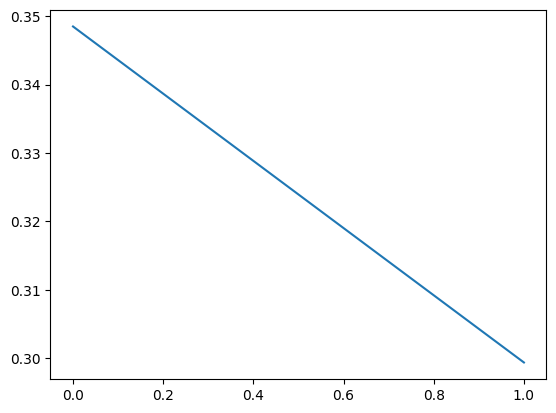

In [350]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [351]:
for layer in model.layers:
    layer.training = False
    

In [352]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9474010467529297
val 2.188141345977783


In [353]:
# sample from the model
for _ in range(50):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

palya.
Soghakshi.
Thith.
Mupgani.
Nardiya.
Shija.
Siraj.
Mabha.
Sajsenv.
Tashnu.
Hamshadhin.
Anshan.
Sinaksha.
Pansol.
Mudktal.
Sarshish.
Atzaj.
Kunsharadhan.
Pubhrushuk.
Parsh.
Nabusbt.
L.
Aluy.
Giumaj.
Mubhej.
Answinya.
Dsepansha.
Ushisha.
Soriyu.
Prajeen.
Prikubh.
Abbbj.
Damiv.
Gith.
Narul.
Viyan.
Pratshana.
Rojponesh.
Ashva.
Ravuditi.
Pmali.
Praneshaar.
NuYrshhaadana.
Mujaty.
Swaliyu.
Yragha.
Divyantn.
Panhau.
Malun.
Muyank.
